In [1103]:
import torch
import pandas as pd

from sklearn.preprocessing import StandardScaler
import us

import random
import sys
import warnings
import time

from metrics import *
from Misc import *
from Classifier import NeuralNetwork, LogisticRegression, SVM, RandomForest, DecisionTree
from utils import *
from DatasetExt import *
from influence import *
from Algorithms import *
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.ticker as mticker
from scipy.linalg import sqrtm
from kneed import KneeLocator

torch.manual_seed(1)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import copy
import sys
import warnings
import pandas as pd
import time
import os
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.linalg import sqrtm
from collections import Counter
from kneed import KneeLocator

import seaborn as sb

In [1104]:
np.random.seed(42)

In [1105]:
dataset_name='employment'

## ACS Dataset

In [1106]:
dataset_orig_df = load_acs_data(dataset_name, year='2018', states=['CA'])
Target_attribute, Sensitive_attribute, protected_group, privileged_group= get_target_sensitive_attribute(dataset_name)

In [1107]:
test_orig_df, datapool = train_test_split(dataset_orig_df, test_size=0.8, random_state=42)

## Adult and Credit Dataset

In [1108]:
#datapool, test_orig_df=load_data(dataset_name)
#Target_attribute, Sensitive_attribute, protected_group, privileged_group= get_target_sensitive_attribute(dataset_name)
#dataset_orig_df = pd.concat([datapool, test_orig_df], ignore_index=True)

## Define Training and Budget Percentages

In [1109]:
train_pct=5
train_size=int(dataset_orig_df.shape[0]*(train_pct/100))

In [1110]:
train_smart_df= smart_sample(datapool, train_size , 50, 90 , dataset_name)  #keep it balance for the sake of accuracy
datapool = datapool.drop(train_smart_df.index)

In [1111]:
print("Original dataset: ", dataset_orig_df.shape)
print("Train set: ", train_smart_df.shape)
print("Test set: ", test_orig_df.shape)
print("Size of Data Pool: ", datapool.shape)

Original dataset:  (378817, 17)
Train set:  (18940, 17)
Test set:  (75763, 17)
Size of Data Pool:  (284114, 17)


In [1112]:
budget_pct=20
data_acq_size=int(datapool.shape[0]*budget_pct/100)
mini_batch_size=int(data_acq_size*(15/100))
print('mini batch size', mini_batch_size)
print('Budget Size', data_acq_size)

mini batch size 8523
Budget Size 56822


## Initial Model Training

In [1113]:
x=int(data_acq_size/mini_batch_size)
print(x)

6


In [1114]:
X_train = train_smart_df.drop(columns=[Target_attribute])
y_train = train_smart_df[Target_attribute]
X_test = test_orig_df.drop(columns=[Target_attribute])
y_test = test_orig_df[Target_attribute]

In [1115]:
model_smart=LogisticRegression(input_size=X_train.shape[-1])

In [1116]:
X_train, X_test, y_train, y_test, X_train_orig, X_test_orig=prepare_train_data(train_smart_df, test_orig_df, Target_attribute)

In [1117]:
num_params = len(convert_grad_to_ndarray(list(model_smart.parameters())))
if isinstance(model_smart, LogisticRegression):
    loss_func = logistic_loss_torch
elif isinstance(model_smart, SVM):
    loss_func = svm_loss_torch
elif isinstance(model_smart, NeuralNetwork):
    loss_func = nn_loss_torch

In [1118]:
model_smart.fit(X_train, y_train)
y_pred_test = model_smart.predict_proba(X_test)
y_pred_train = model_smart.predict_proba(X_train)

In [1119]:
#privileged_positive, privileged_negative, protected_positive, protected_negative, privileged_data_full, protected_data_full=get_group_count(train_smart_df, dataset_name)

In [1120]:
spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset_name)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset_name)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)


Initial statistical parity:  -0.28901918984126834
Initial TPR parity:  -0.27687309673105576
Initial predictive parity:  -0.004352194509710139
Initial loss:  0.6641965302156447
Initial accuracy:  0.6909705265103019


In [1121]:
ini_parity=spd_0
X_train_full, X_test_full, y_train_full, y_test_full, X_train_orig_full, X_test_orig_full=prepare_train_data(dataset_orig_df, test_orig_df, Target_attribute)
model_full=copy.deepcopy(model_smart)
model_full.fit(X_train_full, y_train_full)   
y_pred_test_full=model_full.predict_proba(X_test)
full_parity = computeFairness(y_pred_test_full, X_test_orig, y_test, 0, dataset_name)
ini_acc=computeAccuracy(y_test_full, y_pred_test_full)
print('ini parity', ini_parity)
print('model_full', full_parity)

ini parity -0.28901918984126834
model_full -0.046669346548514734


In [1122]:
privileged_positive, privileged_negative, protected_positive, protected_negative, privieleged_data_full, protected_data_full = get_group_count(dataset_orig_df, dataset_name)

## Distribution Check

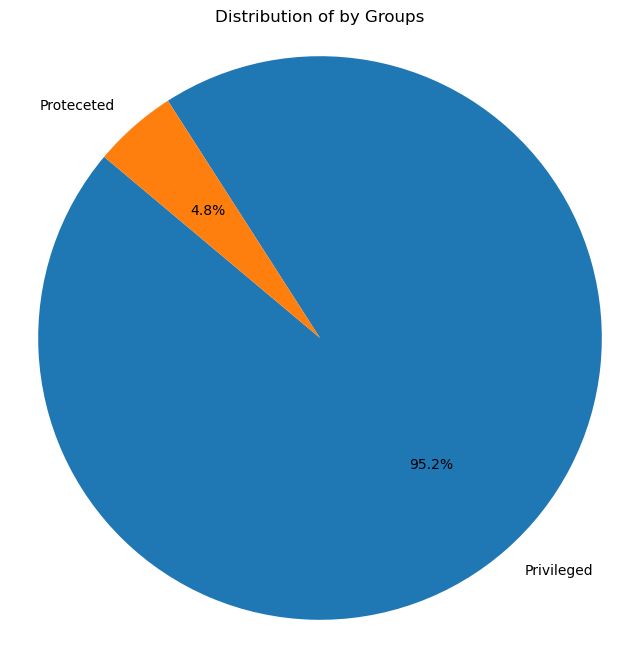

In [1123]:
labels = ['Privileged', 'Proteceted']
values = [privieleged_data_full.shape[0], protected_data_full.shape[0]]


plt.figure(figsize=(8, 8))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of by Groups')
plt.axis('equal')
plt.show()

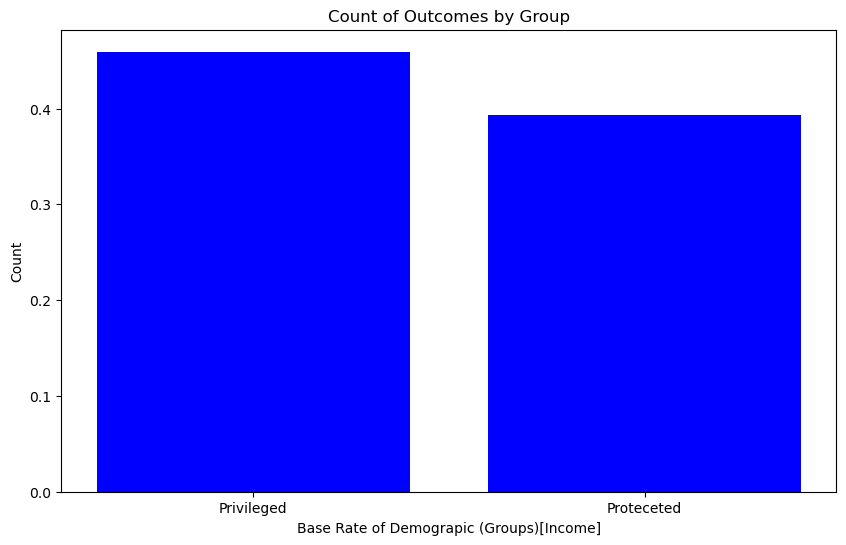

In [1124]:
labels = ['Privileged', 'Proteceted']
values = [privileged_positive.shape[0]/privieleged_data_full.shape[0], protected_positive.shape[0]/protected_data_full.shape[0]]

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'blue', 'green', 'green'])
plt.xlabel('Base Rate of Demograpic (Groups)[Income]')
plt.ylabel('Count')
plt.title('Count of Outcomes by Group')
plt.show()

In [1125]:
print("Total Privileged count: ", privieleged_data_full.shape)
print("Total Protected count: ", protected_data_full.shape)
print("Privileged with Positive Outcome: ", privileged_positive.shape)
print("Privileged with Negative Outcome: ", privileged_negative.shape)
print("Protected with Positive Outcome: ", protected_positive.shape)
print("Protected with Negative Outcome: ", protected_negative.shape)

Total Privileged count:  (360579, 17)
Total Protected count:  (18238, 17)
Privileged with Positive Outcome:  (165635, 17)
Privileged with Negative Outcome:  (194944, 17)
Protected with Positive Outcome:  (7168, 17)
Protected with Negative Outcome:  (11070, 17)


## First Order Influence

In [1126]:
'''metric = 0  # spd -> 0, tpr parity -> 1, predictive parity -> 2
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]

v1 = get_del_F_del_theta(model_smart, X_test_orig, X_test, y_test, dataset_name, metric)
v1=v1.reshape(-1,1)

hessian_all_points = get_hessian_all_points(model_smart, X_train, y_train, loss_func)
del_L_del_theta = get_del_L_del_theta(model_smart, X_train, y_train, loss_func)
hinv_v, hinv = get_hinv_v(hessian_all_points, v1)
Inf_par=-(1/X_train.shape[0])*(-del_L_del_theta@hinv)
Influence_loss= -np.dot(hinv, del_L_del_theta.T)
Influence_loss=Influence_loss
Influence_fair=Inf_par@v1'''

'metric = 0  # spd -> 0, tpr parity -> 1, predictive parity -> 2\nmetric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]\n\nv1 = get_del_F_del_theta(model_smart, X_test_orig, X_test, y_test, dataset_name, metric)\nv1=v1.reshape(-1,1)\n\nhessian_all_points = get_hessian_all_points(model_smart, X_train, y_train, loss_func)\ndel_L_del_theta = get_del_L_del_theta(model_smart, X_train, y_train, loss_func)\nhinv_v, hinv = get_hinv_v(hessian_all_points, v1)\nInf_par=-(1/X_train.shape[0])*(-del_L_del_theta@hinv)\nInfluence_loss= -np.dot(hinv, del_L_del_theta.T)\nInfluence_loss=Influence_loss\nInfluence_fair=Inf_par@v1'

In [1127]:
'''X_train_copy = X_train.copy()
y_train_copy = y_train.copy()
difference = []

for index in range(X_train_copy.shape[0]):
    df_dropped_X = np.delete(X_train_copy, index, axis=0)
    df_dropped_y = np.delete(y_train_copy, index, axis=0)
    model = LogisticRegression(input_size=df_dropped_X.shape[-1])
    model.fit(df_dropped_X, df_dropped_y)
    y_pred_test = model.predict_proba(X_test)
    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)
    parity_diff = parity - spd_0
    difference.append(parity_diff)'''

'X_train_copy = X_train.copy()\ny_train_copy = y_train.copy()\ndifference = []\n\nfor index in range(X_train_copy.shape[0]):\n    df_dropped_X = np.delete(X_train_copy, index, axis=0)\n    df_dropped_y = np.delete(y_train_copy, index, axis=0)\n    model = LogisticRegression(input_size=df_dropped_X.shape[-1])\n    model.fit(df_dropped_X, df_dropped_y)\n    y_pred_test = model.predict_proba(X_test)\n    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)\n    parity_diff = parity - spd_0\n    difference.append(parity_diff)'

In [1128]:
'''plt.figure(figsize=(8, 6))
plt.scatter(difference, Influence_fair, color='b', label='Influence vs Difference', marker='o')
x_values = np.linspace(min(difference), max(difference), 100)
plt.plot(x_values, x_values, color='g', label='y = x', linestyle='-')
plt.xlabel('Difference')
plt.ylabel('Influence Fair')
plt.title('Influence Fair vs Difference')
plt.legend()
plt.grid(True)
plt.show()'''

"plt.figure(figsize=(8, 6))\nplt.scatter(difference, Influence_fair, color='b', label='Influence vs Difference', marker='o')\nx_values = np.linspace(min(difference), max(difference), 100)\nplt.plot(x_values, x_values, color='g', label='y = x', linestyle='-')\nplt.xlabel('Difference')\nplt.ylabel('Influence Fair')\nplt.title('Influence Fair vs Difference')\nplt.legend()\nplt.grid(True)\nplt.show()"

## Second Order Influence

In [1129]:
#mini_batches = get_minibatches(X_train_orig, mini_batch_size)


In [1130]:
'''second_order_influences = []
v1_orig = v1

for batch in mini_batches:
    idx=batch.index
    params_f_2 = second_order_group_influence(idx, del_L_del_theta, hessian_all_points, hinv)
    del_f_2 = np.dot(v1.transpose(), params_f_2)
    second_order_influences.append(del_f_2)'''

'second_order_influences = []\nv1_orig = v1\n\nfor batch in mini_batches:\n    idx=batch.index\n    params_f_2 = second_order_group_influence(idx, del_L_del_theta, hessian_all_points, hinv)\n    del_f_2 = np.dot(v1.transpose(), params_f_2)\n    second_order_influences.append(del_f_2)'

In [1131]:
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

## First Order ground truth check

In [1132]:
'''num_batches = (X_train_copy.shape[0] + mini_batch_size - 1) // mini_batch_size
cum_group_inf=[]
for batch in range(num_batches):
    start_index = batch * mini_batch_size
    end_index = start_index + mini_batch_size
    group_inf=Influence_fair[start_index:end_index].sum()
    cum_group_inf.append(group_inf)'''

'num_batches = (X_train_copy.shape[0] + mini_batch_size - 1) // mini_batch_size\ncum_group_inf=[]\nfor batch in range(num_batches):\n    start_index = batch * mini_batch_size\n    end_index = start_index + mini_batch_size\n    group_inf=Influence_fair[start_index:end_index].sum()\n    cum_group_inf.append(group_inf)'

In [1133]:
'''difference_group = []
for batch in range(num_batches):
    start_index = batch * mini_batch_size
    end_index = min(start_index + mini_batch_size, X_train_copy.shape[0])
    df_dropped_X = np.delete(X_train_copy, slice(start_index, end_index), axis=0)
    df_dropped_y = np.delete(y_train_copy, slice(start_index, end_index), axis=0)
    model_idx= copy.deepcopy(model_smart)
    model_idx.fit(df_dropped_X, df_dropped_y)
    y_pred_test = model_idx.predict_proba(X_test)
    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)
    parity_diff = parity - spd_0
    difference_group.append(parity_diff)
'''

'difference_group = []\nfor batch in range(num_batches):\n    start_index = batch * mini_batch_size\n    end_index = min(start_index + mini_batch_size, X_train_copy.shape[0])\n    df_dropped_X = np.delete(X_train_copy, slice(start_index, end_index), axis=0)\n    df_dropped_y = np.delete(y_train_copy, slice(start_index, end_index), axis=0)\n    model_idx= copy.deepcopy(model_smart)\n    model_idx.fit(df_dropped_X, df_dropped_y)\n    y_pred_test = model_idx.predict_proba(X_test)\n    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)\n    parity_diff = parity - spd_0\n    difference_group.append(parity_diff)\n'

In [1134]:
'''plt.figure(figsize=(8, 6))
plt.scatter(difference_group, second_order_influences , color='r', label='Second Order Influence vs Difference_LOO', marker='o')
plt.scatter(difference_group, cum_group_inf, color='b', label='First Order Sum vs Difference_LOO', marker='o')
x_values = np.linspace(min(second_order_influences), max(second_order_influences), 100)
plt.plot(x_values, x_values, color='g', label='y = x', linestyle='-')
plt.xlabel('Difference_LOO')
plt.ylabel('Influence')
plt.title('First Order Sum vs Difference_LOO')
plt.legend()
plt.grid(True)
plt.show()'''

"plt.figure(figsize=(8, 6))\nplt.scatter(difference_group, second_order_influences , color='r', label='Second Order Influence vs Difference_LOO', marker='o')\nplt.scatter(difference_group, cum_group_inf, color='b', label='First Order Sum vs Difference_LOO', marker='o')\nx_values = np.linspace(min(second_order_influences), max(second_order_influences), 100)\nplt.plot(x_values, x_values, color='g', label='y = x', linestyle='-')\nplt.xlabel('Difference_LOO')\nplt.ylabel('Influence')\nplt.title('First Order Sum vs Difference_LOO')\nplt.legend()\nplt.grid(True)\nplt.show()"

## Clustering

In [1135]:
def gmm_clustering(data):
    n_components_range=range(1, 11)
    random_state=42
    bic_scores = []
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=random_state)
        gmm.fit(data)
        bic_scores.append(gmm.bic(data))

    kneedle_gmm = KneeLocator(list(n_components_range), bic_scores, curve="convex", direction="decreasing")
    optimal_num_components_gmm = kneedle_gmm.knee

    plt.plot(n_components_range, bic_scores, marker='o')
    plt.title('GMM Knee Plot')
    plt.xlabel('Number of Components')
    plt.ylabel('BIC Score')
    plt.axvline(optimal_num_components_gmm, color='r', linestyle='--', label='Optimal Number of Components')
    plt.legend()
    plt.show()

    gmm = GaussianMixture(n_components=optimal_num_components_gmm, random_state=random_state)
    gmm.fit(data)
    clusters_gmm = gmm.predict(data)

    clustered_data = []
    for i in range(optimal_num_components_gmm):
        cluster_i_indices = np.where(clusters_gmm == i)[0]
        cluster_i_data = data.iloc[cluster_i_indices, :]
        clustered_data.append(cluster_i_data)
        print(f"Cluster {i+1} shape: {cluster_i_data.shape}")
    
    return clustered_data

In [1136]:
#clustered_data=gmm_clustering(datapool)

## Influence Estimation for Data Pool

## K-NN

In [1137]:
'''sort_by_inf_partition = []
sort_by_inf = []
for data in clustered_data:
    sorted_cluster_data, sorted_influences_fair = sorted_influence_KNN(train_smart_df, data, Influence_fair, k=100)
    sort_by_inf_partition.append(sorted_cluster_data)
    sort_by_inf.append(sorted_influences_fair)'''

'sort_by_inf_partition = []\nsort_by_inf = []\nfor data in clustered_data:\n    sorted_cluster_data, sorted_influences_fair = sorted_influence_KNN(train_smart_df, data, Influence_fair, k=100)\n    sort_by_inf_partition.append(sorted_cluster_data)\n    sort_by_inf.append(sorted_influences_fair)'

## Regression

In [1138]:
model_ridge, X_test_poly, y_test_inf= train_reg_model(train_smart_df, Influence_fair, 'Influence')

Ridge R-squared (R²): 0.9973357333174794


In [1139]:
y_pred_inf = model_ridge.predict(X_test_poly)

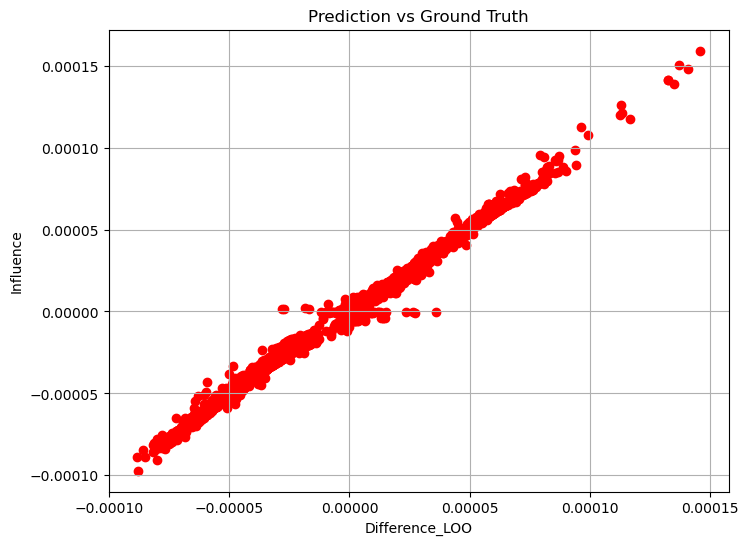

In [1140]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_inf, y_test_inf , color='r', label='Second Order Influence vs Difference_LOO', marker='o')
plt.xlabel('Difference_LOO')
plt.ylabel('Influence')
plt.title('Prediction vs Ground Truth')
plt.grid(True)
plt.show()

In [1141]:
#sorted_cluster_data, sorted_influences = sorted_influences_reg(datapool, model_ridge)

In [1142]:
sort_by_inf_partition = []
sort_by_inf = []
for data in clustered_data:
    sorted_cluster_data, sorted_influences = sorted_influences_reg(data, model_ridge)
    sort_by_inf_partition.append(sorted_cluster_data)
    sort_by_inf.append(sorted_influences)

## Second order cluster ground truth check

In [1143]:
'''cluster_ground_truth = []
num_batches = (sort_by_inf_partition[3].shape[0] + mini_batch_size - 1) // mini_batch_size  # Compute number of batches
X_train_cl,_, y_train_cl, _, X_train_orig_cl, _= prepare_train_data(sort_by_inf_partition[3], test_orig_df, Target_attribute)
for batch in range(num_batches):
    start_index = batch * mini_batch_size
    end_index = min(start_index + mini_batch_size, sort_by_inf_partition[3].shape[0])
    df_dropped_X = np.concatenate((X_train, X_train_cl[start_index: end_index]), axis=0)
    df_dropped_y = np.concatenate((y_train, y_train_cl[start_index: end_index]), axis=0)
    model = LogisticRegression(input_size=df_dropped_X.shape[-1])
    model_idx= copy.deepcopy(model)
    model_idx.fit(df_dropped_X, df_dropped_y)
    y_pred_test = model_idx.predict_proba(X_test)
    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)
    parity_diff = parity - spd_0
    cluster_ground_truth.append(parity_diff)'''

'cluster_ground_truth = []\nnum_batches = (sort_by_inf_partition[3].shape[0] + mini_batch_size - 1) // mini_batch_size  # Compute number of batches\nX_train_cl,_, y_train_cl, _, X_train_orig_cl, _= prepare_train_data(sort_by_inf_partition[3], test_orig_df, Target_attribute)\nfor batch in range(num_batches):\n    start_index = batch * mini_batch_size\n    end_index = min(start_index + mini_batch_size, sort_by_inf_partition[3].shape[0])\n    df_dropped_X = np.concatenate((X_train, X_train_cl[start_index: end_index]), axis=0)\n    df_dropped_y = np.concatenate((y_train, y_train_cl[start_index: end_index]), axis=0)\n    model = LogisticRegression(input_size=df_dropped_X.shape[-1])\n    model_idx= copy.deepcopy(model)\n    model_idx.fit(df_dropped_X, df_dropped_y)\n    y_pred_test = model_idx.predict_proba(X_test)\n    parity = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset_name)\n    parity_diff = parity - spd_0\n    cluster_ground_truth.append(parity_diff)'

In [1144]:
'''num_batches = (sort_by_inf[3].shape[0] + mini_batch_size - 1) // mini_batch_size  # Compute number of batches
print(num_batches)
cum_group_inf=[]
for batch in range(num_batches):
    start_index = batch * mini_batch_size
    end_index = start_index + mini_batch_size
    group_inf=sort_by_inf[1][start_index:end_index].sum()
    cum_group_inf.append(-group_inf)'''

'num_batches = (sort_by_inf[3].shape[0] + mini_batch_size - 1) // mini_batch_size  # Compute number of batches\nprint(num_batches)\ncum_group_inf=[]\nfor batch in range(num_batches):\n    start_index = batch * mini_batch_size\n    end_index = start_index + mini_batch_size\n    group_inf=sort_by_inf[1][start_index:end_index].sum()\n    cum_group_inf.append(-group_inf)'

In [1145]:
'''plt.figure(figsize=(8, 6))
plt.plot(range(1,num_batches+1), cum_group_inf, color='r', linestyle='-', label='Estimation for each mini-batch from Cluster')
plt.plot(range(1,num_batches+1), cluster_ground_truth, color='g', linestyle='-', label='Ground Truth')
plt.xlabel('Batches')
plt.ylabel('Estimated Influence for cluster')
plt.title('Ground Truth Vs Estimation')
plt.legend()
plt.grid(True)
plt.show()'''

"plt.figure(figsize=(8, 6))\nplt.plot(range(1,num_batches+1), cum_group_inf, color='r', linestyle='-', label='Estimation for each mini-batch from Cluster')\nplt.plot(range(1,num_batches+1), cluster_ground_truth, color='g', linestyle='-', label='Ground Truth')\nplt.xlabel('Batches')\nplt.ylabel('Estimated Influence for cluster')\nplt.title('Ground Truth Vs Estimation')\nplt.legend()\nplt.grid(True)\nplt.show()"

## Equal Representation

In [1146]:
'''protected_full_sample = protected_data_full.sample(n=int(data_acq_size/2), random_state=42)
privileged_full_sample = privieleged_data_full.sample(n=int(data_acq_size/2), random_state=42)
print(protected_full_sample.shape)'''

'protected_full_sample = protected_data_full.sample(n=int(data_acq_size/2), random_state=42)\nprivileged_full_sample = privieleged_data_full.sample(n=int(data_acq_size/2), random_state=42)\nprint(protected_full_sample.shape)'

In [1147]:
'''from copy import deepcopy

parity_differences = [ini_parity]
percentages = [0.2, 0.4, 0.6, 0.8, 1.0]
for pct in percentages:
    protected_sample = protected_full_sample.sample(frac=pct, random_state=42)
    privileged_sample = privileged_full_sample.sample(n=protected_sample.shape[0], random_state=42)

    full_sample = pd.concat([protected_sample, privileged_sample])
    combined_sample_pct=pd.concat([train_smart_df, full_sample])
    
    X_train_pct, X_test_pct, y_train_pct, y_test_pct, X_train_orig_pct, X_test_orig_pct=prepare_train_data(combined_sample_pct, test_orig_df, Target_attribute)
    model_pct=LogisticRegression(input_size=X_train_pct.shape[-1])
    model_pct.fit(X_train_pct, y_train_pct)
   
    y_pred_test_pct=model_pct.predict_proba(X_test)
    parity = computeFairness(y_pred_test_pct, X_test_orig_pct, y_test_pct, 0, dataset_name)
    parity_differences.append(parity)
percentages.insert(0,0)'''

'from copy import deepcopy\n\nparity_differences = [ini_parity]\npercentages = [0.2, 0.4, 0.6, 0.8, 1.0]\nfor pct in percentages:\n    protected_sample = protected_full_sample.sample(frac=pct, random_state=42)\n    privileged_sample = privileged_full_sample.sample(n=protected_sample.shape[0], random_state=42)\n\n    full_sample = pd.concat([protected_sample, privileged_sample])\n    combined_sample_pct=pd.concat([train_smart_df, full_sample])\n    \n    X_train_pct, X_test_pct, y_train_pct, y_test_pct, X_train_orig_pct, X_test_orig_pct=prepare_train_data(combined_sample_pct, test_orig_df, Target_attribute)\n    model_pct=LogisticRegression(input_size=X_train_pct.shape[-1])\n    model_pct.fit(X_train_pct, y_train_pct)\n   \n    y_pred_test_pct=model_pct.predict_proba(X_test)\n    parity = computeFairness(y_pred_test_pct, X_test_orig_pct, y_test_pct, 0, dataset_name)\n    parity_differences.append(parity)\npercentages.insert(0,0)'

In [1148]:
'''folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/MAB Data Acqusiition/Plots/Equal_Representation'
file_name = 'equal_representation_uneq.pdf'

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.figure(figsize=(8, 6))
#plt.plot(percentages, parity_differences_eq, marker='s', color='b', label='Balance Training Data')
plt.plot(percentages, parity_differences, marker='s', color='r', label='Imbalance Training Data')

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
plt.xlabel('Acquired Data Percentages of Budget (Equal Representation)')
plt.ylabel('Fairness Metric')
plt.legend(loc='lower right', bbox_to_anchor=(0.95, 0.05))'''

#plt.savefig(file_path, format='pdf', dpi=600)

"folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/MAB Data Acqusiition/Plots/Equal_Representation'\nfile_name = 'equal_representation_uneq.pdf'\n\nos.makedirs(folder_path, exist_ok=True)\nfile_path = os.path.join(folder_path, file_name)\n\nplt.figure(figsize=(8, 6))\n#plt.plot(percentages, parity_differences_eq, marker='s', color='b', label='Balance Training Data')\nplt.plot(percentages, parity_differences, marker='s', color='r', label='Imbalance Training Data')\n\nplt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))\nplt.xlabel('Acquired Data Percentages of Budget (Equal Representation)')\nplt.ylabel('Fairness Metric')\nplt.legend(loc='lower right', bbox_to_anchor=(0.95, 0.05))"

In [1149]:
'''table_eq = {
    'Acquired Data Percentages of Budget (%)': [int(pct * 100) for pct in percentages],
    'Fairness Metric': parity_differences
}

table = pd.DataFrame(table_eq)
table['Acquired Data Percentages of Budget (%)'] = table['Acquired Data Percentages of Budget (%)'].apply(lambda x: f'{x}%')
table.iloc[0, 0] = 'Initial'
table['Fairness Metric'] = table['Fairness Metric'].round(2)
file_path = os.path.join(folder_path, "fairness_metric_table_uneq_train.jpg")

plt.figure(figsize=(8, 1.8))
plt.table(cellText=table.values, colLabels=table.columns, cellLoc='center', loc='center', colColours=["lightblue"]*2)
plt.axis('off')
plt.title('Training Data has Imbalance Representation(Equal Representation)')

#plt.savefig(file_path, format='jpg', bbox_inches='tight', dpi=600)

plt.show()'''

'table_eq = {\n    \'Acquired Data Percentages of Budget (%)\': [int(pct * 100) for pct in percentages],\n    \'Fairness Metric\': parity_differences\n}\n\ntable = pd.DataFrame(table_eq)\ntable[\'Acquired Data Percentages of Budget (%)\'] = table[\'Acquired Data Percentages of Budget (%)\'].apply(lambda x: f\'{x}%\')\ntable.iloc[0, 0] = \'Initial\'\ntable[\'Fairness Metric\'] = table[\'Fairness Metric\'].round(2)\nfile_path = os.path.join(folder_path, "fairness_metric_table_uneq_train.jpg")\n\nplt.figure(figsize=(8, 1.8))\nplt.table(cellText=table.values, colLabels=table.columns, cellLoc=\'center\', loc=\'center\', colColours=["lightblue"]*2)\nplt.axis(\'off\')\nplt.title(\'Training Data has Imbalance Representation(Equal Representation)\')\n\n#plt.savefig(file_path, format=\'jpg\', bbox_inches=\'tight\', dpi=600)\n\nplt.show()'

## MAB Acquisition

In [1150]:
Stat_update_data, i_values_stat, i_values_ex_stat, stat_ex, stat, acc_stat, time_per_iteration_stat, cluster_count, iteration_time1 = mab_algorithm(clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, max_iteration=150, tau=0.01, budget=data_acq_size)

## MAB_INF Acquisition

In [1151]:
MAB_inf_update_data, MAB_inf_iteration_count, MAB_inf_iteration_count_ex, MAB_inf_parity_ex, stat_inf, MAB_inf_accuracy_ex, MAB_inf_time_per_iteration, MAB_inf_cluster_count, iteration_time_MAB_inf = mab_inf_algorithm(sort_by_inf_partition, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, max_iteration=50, tau=0.01, budget=data_acq_size)

## MAB_dist

In [1152]:
#Stat_update_data_dist, i_values_stat_dist, i_values_ex_stat_dist, stat_ex_dist, stat_dist, acc_stat_dist, time_per_iteration_stat_dist, cluster_count_dist, iteration_time1_dist = mab_algorithm_dist(clustered_data, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, max_iteration=50, tau=0.01, budget=data_acq_size, Euclid_normalized_d=normalized_distance)

## Random Acquisition

In [1153]:
data_random, i_values_ex_ran, i_values_ran, stat_ran, stat_ex_ran, acc_ran, time_per_iteration_ran =random_algorithm(datapool, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, tau=.01, budget=data_acq_size)

In [1154]:
data_random.shape

(75762, 17)

In [1155]:
'''import matplotlib.ticker as mticker
folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/MAB Data Acqusiition/Plots/Equal_Representation'
file_name = 'Eq_Random_Acq.pdf'

os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.figure(figsize=(8, 6))
#plt.plot(percentages, stat_ran, marker='s', color='b', label='ImBalance Training Data')
#plt.plot(percentages, stat_ran_eq, marker='s', color='b', label='Balanced TD: Random Acquisition')
plt.plot(percentages, stat_ran, marker='s', color='r', label='Imbalanced TD: Random Acquisition')
#plt.plot(percentages, parity_differences_eq, marker='s', color='lightblue', label='Balanced TD: Equal Representation')
plt.plot(percentages, parity_differences, marker='s', color='orange', label='Imbalanced TD: Equal Representation')

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
plt.xlabel('Acquired Data Percentages of Budget')
plt.ylabel('Fairness Metric')
plt.legend(loc='lower right', bbox_to_anchor=(0.95, 0.05))

plt.savefig(file_path, format='pdf', dpi=600)'''

"import matplotlib.ticker as mticker\nfolder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/MAB Data Acqusiition/Plots/Equal_Representation'\nfile_name = 'Eq_Random_Acq.pdf'\n\nos.makedirs(folder_path, exist_ok=True)\nfile_path = os.path.join(folder_path, file_name)\n\nplt.figure(figsize=(8, 6))\n#plt.plot(percentages, stat_ran, marker='s', color='b', label='ImBalance Training Data')\n#plt.plot(percentages, stat_ran_eq, marker='s', color='b', label='Balanced TD: Random Acquisition')\nplt.plot(percentages, stat_ran, marker='s', color='r', label='Imbalanced TD: Random Acquisition')\n#plt.plot(percentages, parity_differences_eq, marker='s', color='lightblue', label='Balanced TD: Equal Representation')\nplt.plot(percentages, parity_differences, marker='s', color='orange', label='Imbalanced TD: Equal Representation')\n\nplt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))\nplt.xlabel('Acquired Data Percentag

In [1156]:
'''table_eq = {
    'Acquired Data Percentages of Budget (%)': [int(pct * 100) for pct in percentages],
    'Fairness Metric': stat_ran
}

table = pd.DataFrame(table_eq)
table['Acquired Data Percentages of Budget (%)'] = table['Acquired Data Percentages of Budget (%)'].apply(lambda x: f'{x}%')
table.iloc[0, 0] = 'Initial'
table['Fairness Metric'] = table['Fairness Metric'].round(2)
file_path = os.path.join(folder_path, "fairness_metric_table_ran_uneq_train.jpg")

plt.figure(figsize=(8, 1.8))
plt.table(cellText=table.values, colLabels=table.columns, cellLoc='center', loc='center', colColours=["lightblue"]*2)
plt.axis('off')
plt.title('Training Data has Imbalance Representation(Random)')

plt.savefig(file_path, format='jpg', bbox_inches='tight', dpi=600)

plt.show()'''

'table_eq = {\n    \'Acquired Data Percentages of Budget (%)\': [int(pct * 100) for pct in percentages],\n    \'Fairness Metric\': stat_ran\n}\n\ntable = pd.DataFrame(table_eq)\ntable[\'Acquired Data Percentages of Budget (%)\'] = table[\'Acquired Data Percentages of Budget (%)\'].apply(lambda x: f\'{x}%\')\ntable.iloc[0, 0] = \'Initial\'\ntable[\'Fairness Metric\'] = table[\'Fairness Metric\'].round(2)\nfile_path = os.path.join(folder_path, "fairness_metric_table_ran_uneq_train.jpg")\n\nplt.figure(figsize=(8, 1.8))\nplt.table(cellText=table.values, colLabels=table.columns, cellLoc=\'center\', loc=\'center\', colColours=["lightblue"]*2)\nplt.axis(\'off\')\nplt.title(\'Training Data has Imbalance Representation(Random)\')\n\nplt.savefig(file_path, format=\'jpg\', bbox_inches=\'tight\', dpi=600)\n\nplt.show()'

## Entropy-Based Acquisition

In [1157]:
Data_entrophy, i_values_ex_ent, i_values_ent, stat_ent, stat_ex_ent, acc_ent, time_per_iteration_ent=entropy_based_algorithm(datapool, dataset_name, train_smart_df, test_orig_df, model_smart, Target_attribute, mini_batch_size=mini_batch_size, tau=.01, budget=data_acq_size)

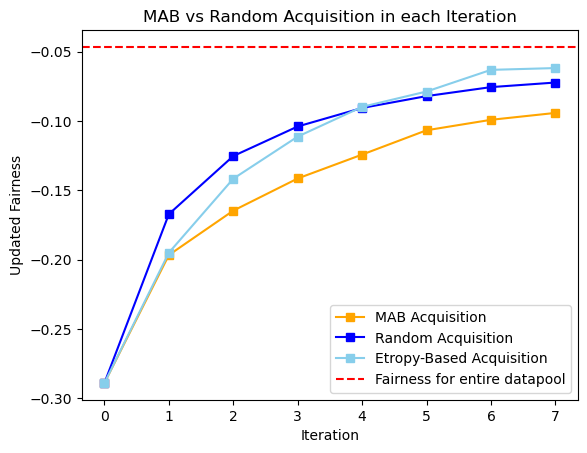

In [1158]:
#plt.plot(MAB_inf_iteration_count, stat_inf,color='g',marker='s', linestyle='-', label='MAB_INF Acquisition')
plt.plot(i_values_stat, stat, color='orange', marker='s', linestyle='-', label='MAB Acquisition')
plt.plot(i_values_ran, stat_ran, color='b', marker='s', linestyle='-', label='Random Acquisition')
plt.plot(i_values_ent, stat_ent, color='skyblue', marker='s', linestyle='-', label='Etropy-Based Acquisition')
#plt.axhline(y=ini_parity, color='r', linestyle='--', label='Initial fairness')
plt.axhline(y=full_parity, color='r', linestyle='--', label='Fairness for entire datapool')
plt.xlabel('Iteration')
plt.ylabel('Updated Fairness')
plt.title('MAB vs Random Acquisition in each Iteration')
plt.legend()
plt.savefig('combined_plot.png', dpi=1200)
plt.show()

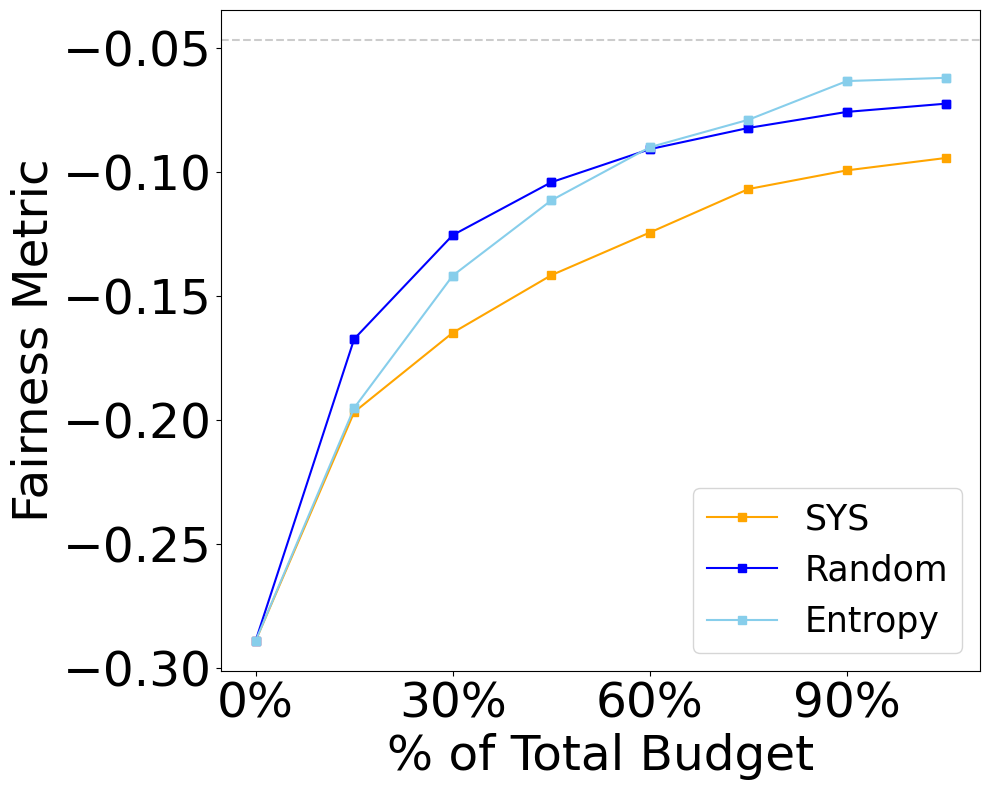

In [1159]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Define folder path and file name
folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Sys for different model'
file_name = 'Income_SVM.pdf'

# Create the directory if it doesn't exist
os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

# Set the figure size while keeping the aspect ratio the same
plt.figure(figsize=(10,8))  # Adjust the values as needed, keeping the same ratio

# Plotting with filtering inside the plot command
plt.plot(
    [i for i in i_values_ex_stat if i % 1 == 0], 
    [stat_ex[i_values_ex_stat.index(i)] for i in i_values_ex_stat if i % 1 == 0], 
    color='orange', marker='s', linestyle='-', label='SYS'
)

plt.plot(
    [i for i in i_values_ex_ran if i % 1 == 0], 
    [stat_ex_ran[i_values_ex_ran.index(i)] for i in i_values_ex_ran if i % 1 == 0], 
    color='b', marker='s', linestyle='-', label='Random'
)

plt.plot(
    [i for i in i_values_ex_ent if i % 1 == 0], 
    [stat_ex_ent[i_values_ex_ent.index(i)] for i in i_values_ex_ent if i % 1 == 0], 
    color='skyblue', marker='s', linestyle='-', label='Entropy'
)

# Horizontal line for full parity
plt.axhline(y=full_parity, color='black', alpha=0.2, linestyle='--')

# Format x-axis
plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)

# Labels and legend with increased font size
plt.xlabel('% of Total Budget', fontsize=35)
plt.ylabel('Fairness Metric', fontsize=35)
plt.legend(loc='lower right', bbox_to_anchor=(0.999, 0.001), fontsize=25)

# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=35)

# Adjust layout to prevent cropping
plt.tight_layout()

# Save the figure and show the plot
#plt.savefig(file_path, format='pdf', dpi=600)
plt.show()



<Figure size 640x480 with 0 Axes>

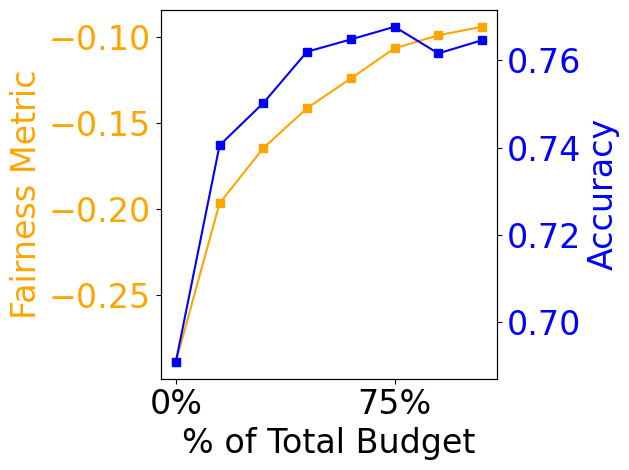

In [1160]:
import os
import matplotlib.pyplot as plt

# Define folder path and file name
folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots/Sys for different model'
file_name = 'trade-off.pdf'  # Corrected to remove the extra '.pdf'

# Create the directory if it doesn't exist
os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

# Create a rectangular figure (e.g., 12 inches wide and 6 inches tall)
plt.figure(figsize=(6.4, 4.8))  
fig, ax1 = plt.subplots(figsize=(6.4, 4.8))  # Adjusted to be rectangular

line1, = ax1.plot(
    i_values_ex_stat, 
    stat_ex,
    color='orange', marker='s', linestyle='-', label='SYS'
)

ax1.set_xlabel('% of Total Budget', fontsize=24)
ax1.set_ylabel('Fairness Metric', color='orange', fontsize=24)
ax1.tick_params(axis='y', labelcolor='orange', labelsize=24)
ax1.tick_params(axis='x', labelsize=24) 

# Create second y-axis
ax2 = ax1.twinx()  

line2, = ax2.plot(
    i_values_ex_stat, 
    acc_stat, 
    color='blue', marker='s', linestyle='-', label='Accuracy'
)

ax2.set_ylabel('Accuracy', color='blue', fontsize=24)
ax2.tick_params(axis='y', labelcolor='blue', labelsize=24)
plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)
# Adjust layout to prevent clipping
plt.tight_layout()

# Save the figure and show the plot
plt.savefig(file_path, format='pdf', dpi=600)
plt.show()


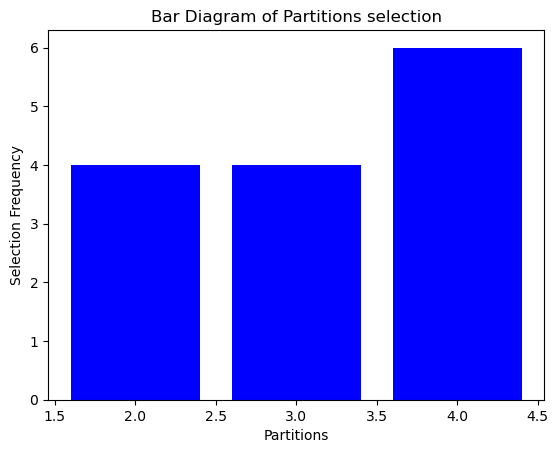

In [1161]:
plt.figure(2)
data = cluster_count
counter = Counter(data)

numbers = list(counter.keys())
frequencies = list(counter.values())

plt.bar(numbers, frequencies, color='blue')
plt.xlabel('Partitions')
plt.ylabel('Selection Frequency')
plt.title('Bar Diagram of Partitions selection')

plt.show()

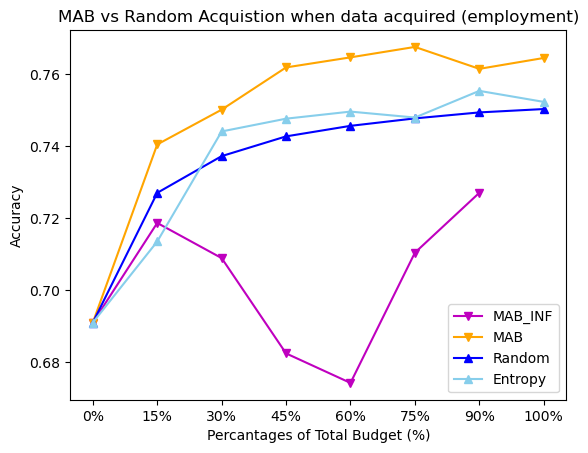

In [1162]:
folder_path = '/Users/hasan89/Library/CloudStorage/OneDrive-purdue.edu/Ph.D. Resource/Research Code/Plots'
file_name = 'travel_methods_acc.pdf'
os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, file_name)

plt.plot(MAB_inf_iteration_count_ex, MAB_inf_accuracy_ex, color='m',marker='v', linestyle='-', label='MAB_INF')
plt.plot(i_values_ex_stat, acc_stat, color='orange',marker='v', linestyle='-', label='MAB')
plt.plot(i_values_ran, acc_ran, color='b', marker='^', linestyle='-', label='Random')
plt.plot(i_values_ent, acc_ent, color='skyblue', marker='^', linestyle='-', label='Entropy')

plt.gca().xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x, _: f'{min(x * (mini_batch_size / data_acq_size) * 100, 100):.0f}%'
    )
)

plt.xlabel('Percantages of Total Budget (%)')
plt.ylabel('Accuracy')
plt.title(f'MAB vs Random Acquistion when data acquired ({dataset_name})')
plt.legend(loc='lower right', bbox_to_anchor=(0.999, 0.001))
plt.savefig(file_path, format='pdf', dpi=600)
plt.show()

In [1163]:
print('Initial Acc', accuracy_0)
print('MAB_INF Accuracy', MAB_inf_accuracy_ex[-1])
print('MAB Accuracy', acc_stat[-1])
print('Random Accuracy', acc_ran[-1])
print('Entropy Accuracy', acc_ent[-1])


Initial Acc 0.6909705265103019
MAB_INF Accuracy 0.7270699417921677
MAB Accuracy 0.7645684568984861
Random Accuracy 0.7503662737747977
Entropy Accuracy 0.7523593310718952


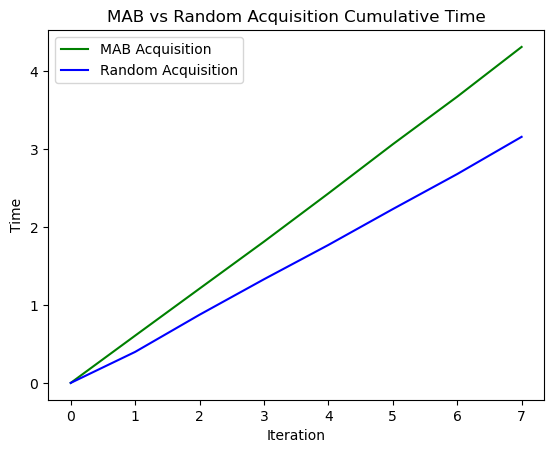

In [1164]:
plt.plot(i_values_stat, time_per_iteration_stat, color='g', linestyle='-', label='MAB Acquisition')
plt.plot(i_values_ran, time_per_iteration_ran, color='b', linestyle='-', label='Random Acquisition')

plt.xlabel('Iteration')
plt.ylabel('Time')
plt.title('MAB vs Random Acquisition Cumulative Time')
plt.legend()
plt.savefig('combined_plot.png', dpi=1200)
plt.show()